In [15]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import IsolationForest
import numpy as np
import matplotlib.pyplot as plt


data = pd.read_parquet('./IDS2017/Final/Combined.parquet')
print(data.columns)

#cout labels 'ATTACK' and 'BENIGN'
atacks = data['Label'].value_counts()
print(atacks)

y = data['Label']
X = data.drop('Label', axis=1)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


iso_forest = IsolationForest(
    n_estimators=100,  # liczba drzew
    max_samples='auto',  # liczba próbek do wyboru z każdego drzewa
    contamination=0.1,  # oczekiwany procent anomalii
    max_features=1.0,  # liczba cech do losowania dla każdego drzewa
    random_state=42
)

iso_forest.fit(X_train)

y_train_pred = iso_forest.predict(X_train)
y_test_pred = iso_forest.predict(X_test)


y_train_pred = np.where(y_train_pred == -1, 1, 0)
y_test_pred = np.where(y_test_pred == -1, 1, 0)


n_anomalies_test = np.sum(y_test_pred)
print(f"Anomalie: {n_anomalies_test}")






Index(['Label', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Bwd Packet Length Max', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Average Packet Size', 'Avg Bwd Segment Size',
       'Fwd Header Length.1', 'Subflow Fwd Bytes', 'Subflow Bwd Bytes'],
      dtype='object')
Label
BENIGN              1014454
DoS Hulk             172846
DDoS                 128014
DoS GoldenEye         10286
DoS slowloris          5385
DoS Slowhttptest       5228
Heartbleed               11
Name: count, dtype: int64
Anomalie: 26777


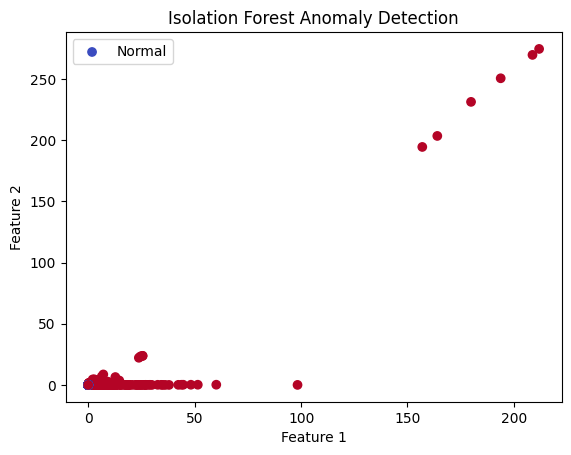

In [16]:

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test_pred, cmap='coolwarm')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(['Normal', 'Anomaly'])
plt.title('Isolation Forest Anomaly Detection')
plt.show()